In [1]:
!pip -q install ultralytics opencv-python pandas


In [3]:
from ultralytics import YOLO
import torch, cv2, os, random, time, json
from pathlib import Path
import pandas as pd

ROOT = Path(r"C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8")     # <-- change if needed
DATA_YAML = ROOT / "data.yaml"
SAMPLES   = ROOT / "samples"      # put 1-2 test images/videos here (optional)
OUT_DIR   = ROOT / "runs_local"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("✳️ Torch:", torch.__version__)
print("✳️ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✳️ Device:", torch.cuda.get_device_name(0))
else:
    print("✳️ Using CPU (that’s fine for a small run).")


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\omar7\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✳️ Torch: 2.9.0+cpu
✳️ CUDA available: False
✳️ Using CPU (that’s fine for a small run).


In [4]:
assert DATA_YAML.exists(), f"data.yaml not found at {DATA_YAML}"
print(DATA_YAML.read_text()[:600])

for split in ["train", "val", "test"]:
    img_dir = ROOT / split / "images"
    lbl_dir = ROOT / split / "labels"
    print(f"{split}: images={len(list(img_dir.glob('*.*')))}  labels={len(list(lbl_dir.glob('*.txt')))}")


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 4
names: ['Entry', 'Rotation', 'TakeOff', 'Underwater']

roboflow:
  workspace: omar-7mdnt
  project: diving-0uoa9
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/omar-7mdnt/diving-0uoa9/dataset/2
train: images=122  labels=122
val: images=0  labels=0
test: images=3  labels=3


In [6]:
DATA_YAML = Path(r"C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\data.yaml")
OUT_DIR   = Path(r"C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\runs_local")
OUT_DIR.mkdir(parents=True, exist_ok=True)

device = "0" if torch.cuda.is_available() else "cpu"

model = YOLO("yolo11n.pt")
model.train(
    data=str(DATA_YAML),
    imgsz=640,
    epochs=20,
    batch=8,
    device=device,
    patience=10,
    project=str(OUT_DIR),
    name="train",
    exist_ok=True
)


Ultralytics 8.3.223  Python-3.13.5 torch-2.9.0+cpu CPU (AMD Ryzen 5 4600H with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001D231CAFEE0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [7]:
BEST = OUT_DIR / "train" / "weights" / "best.pt"
assert BEST.exists(), "best.pt not found—did training complete?"
model = YOLO(str(BEST))

# Run built-in val on your val split
metrics = model.val(data=str(DATA_YAML), device=device)
print("Done. mAP50:", metrics.box.map50 if hasattr(metrics, "box") else "n/a")


Ultralytics 8.3.223  Python-3.13.5 torch-2.9.0+cpu CPU (AMD Ryzen 5 4600H with Radeon Graphics)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 154.936.9 MB/s, size: 27.3 KB)
val: Scanning C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\valid\labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6/6 6.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.9it/s 0.3s
                   all          6          6      0.996       0.96      0.995      0.756
              Rotation          4          4          1      0.921      0.995      0.616
               TakeOff          2          2      0.992          1      0.995      0.895
Speed: 0.9ms preprocess, 47.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to C:\Users\omar7\runs\detect\val
Done. mAP50: 0.995


In [8]:
test_imgs = ROOT / "test" / "images"
pred_out  = OUT_DIR / "pred_images"
pred_out.mkdir(exist_ok=True)

# if you have custom samples, use SAMPLES; else fallback to test images
src_dir = SAMPLES if SAMPLES.exists() else test_imgs

res = model.predict(
    source=str(src_dir),
    conf=0.25,
    device=device,
    save=True,
    project=str(pred_out),
    name="preds",
    exist_ok=True
)
print("Saved image preds to:", pred_out/"preds")



image 1/3 C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\test\images\2538-12_70253_jpg.rf.37c6e9dc413792a59915d2f75eafa0de.jpg: 384x640 1 Rotation, 95.9ms
image 2/3 C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\test\images\2538-12_70258_jpg.rf.bd3bd9120295b88a823fd204ce72f8ec.jpg: 384x640 1 TakeOff, 61.5ms
image 3/3 C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\test\images\2538-12_70263_jpg.rf.13af4ad0a7d73ef1698ceaf93e69a015.jpg: 384x640 1 Rotation, 53.9ms
Speed: 1.9ms preprocess, 70.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\runs_local\pred_images\preds
Saved image preds to: C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\runs_local\pred_images\preds


In [10]:
from collections import deque, Counter

def majority_vote(q):
    return Counter(q).most_common(1)[0][0] if q else "None"

video_path = SAMPLES / r"C:\Users\omar7\Desktop\Dataset\ucf_sports_actions\ucf_sports_actions\ucf action\Diving-Side\001\2538-5_70133.mp4"
if video_path.exists():
    cap = cv2.VideoCapture(str(video_path))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out_path = OUT_DIR / "video_pred.mp4"
    csv_path = OUT_DIR / "video_pred.csv"
    vw = cv2.VideoWriter(str(out_path), fourcc, fps, (W,H))
    names = model.model.names

    window = deque(maxlen=9)
    rows = []
    fidx = 0

    while True:
        ok, frame = cap.read()
        if not ok: break
        r = model.predict(source=frame, conf=0.25, device=device, verbose=False)[0]

        if len(r.boxes) > 0:
            confs = r.boxes.conf.tolist()
            clses = r.boxes.cls.tolist()
            top_i = max(range(len(confs)), key=lambda i: confs[i])
            pred_name = names[int(clses[top_i])]
            pred_conf = float(confs[top_i])
        else:
            pred_name, pred_conf = "None", 0.0

        window.append(pred_name)
        smooth = majority_vote(window)

        cv2.putText(frame, f"{smooth}", (20, 42), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3)
        vw.write(frame)

        rows.append({"frame": fidx, "raw_pred": pred_name, "smooth_pred": smooth, "raw_conf": pred_conf})
        fidx += 1

    cap.release(); vw.release()
    pd.DataFrame(rows).to_csv(csv_path, index=False)
    print("Video saved:", out_path)
    print("CSV saved:", csv_path)
else:
    print("No video at:", video_path, " (drop test.mp4 in Diving/samples/ to use this cell)")


Video saved: C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\runs_local\video_pred.mp4
CSV saved: C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\runs_local\video_pred.csv


Model task: detect
Detections: 1
Classes: ['Entry']
Confs:   ['0.19']


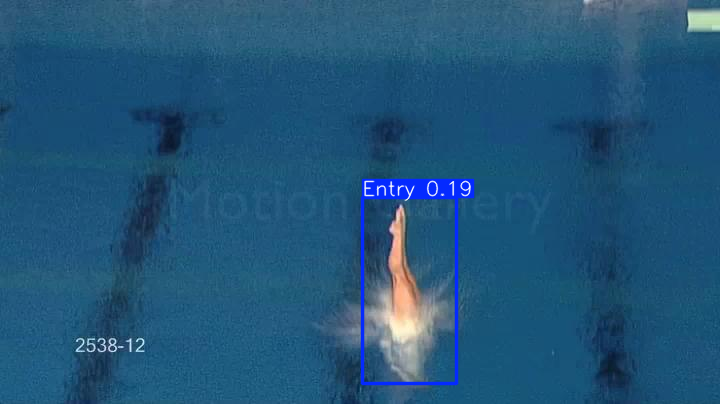

Saved annotated image to: C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\train\images\annotated_preview.jpg


In [18]:
from PIL import Image as PILImage


# ==== EDIT THESE ====
WEIGHTS = r"C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\runs_local\train\weights\best.pt"
IMG     = r"C:\Users\omar7\Desktop\My project\Diving.v2-diving.yolov8\train\images\2538-12_70300_jpg.rf.44ae4579326d0975224a7bebedb39810.jpg"
CONF    = 0.10      
IMGSZ   = 512       
# ====================

assert os.path.exists(WEIGHTS), f"Missing weights: {WEIGHTS}"
assert os.path.exists(IMG),     f"Missing image:   {IMG}"

device = "0" if torch.cuda.is_available() else "cpu"
model  = YOLO(WEIGHTS)

# Sanity: detect vs classify?
print("Model task:", getattr(model.model, "task", "unknown (older ultralytics)"))
# Should print 'detect'. If it says 'classify', you trained/loaded a classification model by mistake.

# Run prediction
res = model.predict(source=IMG, imgsz=IMGSZ, device=device, conf=CONF, save=False, verbose=False)
r = res[0]

# Print what the model actually produced
names = model.model.names
n_boxes = 0 if r.boxes is None else len(r.boxes)
print(f"Detections: {n_boxes}")
if n_boxes:
    clses = [names[int(c)] for c in r.boxes.cls.tolist()]
    confs = [float(c) for c in r.boxes.conf.tolist()]
    print("Classes:", clses)
    print("Confs:  ", [f"{c:.2f}" for c in confs])

# Get annotated image as NumPy (BGR) and convert to RGB for display
annotated_bgr = r.plot()              # draws boxes/labels if there are any
annotated_rgb = annotated_bgr[:, :, ::-1]

# Show inline
display(PILImage.fromarray(annotated_rgb))

# Also save to file so you can open it directly
out_path = Path(os.path.dirname(IMG)) / "annotated_preview.jpg"
PILImage.fromarray(annotated_rgb).save(out_path)
print("Saved annotated image to:", out_path)

